Files already downloaded and verified
Files already downloaded and verified
Epoch 1/1: Train Loss = 1.5891, Train Acc = 41.49%, Test Loss = 1.3005, Test Acc = 52.10%


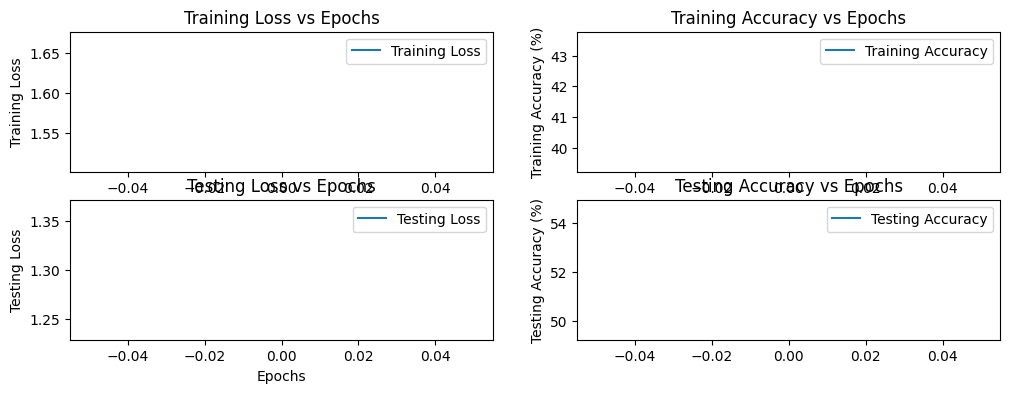

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F

class DeepNet(nn.Module):
    def __init__(self):
        super(DeepNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)  # Dropout layer with 50% probability

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after the first fully connected layer
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the network, loss function, and optimizer
net = DeepNet().to(device)
criterion = nn.CrossEntropyLoss()

# Add weight decay (L2 regularization) to the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)  # Adjust weight decay as needed
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Define data augmentation transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomCrop(32, padding=4),  # Randomly crop images with padding
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image data
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)

# Training loop
num_epochs = 300
train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss_values.append(running_loss / len(trainloader))
    train_acc_values.append(100 * correct / total)

    # Test the network
    net.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Update the learning rate for this epoch
    scheduler.step()

    test_loss_values.append(test_loss / len(testloader))
    test_acc_values.append(100 * correct / total)
    net.train()

    print(f"Epoch {epoch + 1}/{num_epochs}: "
        f"Train Loss = {train_loss_values[-1]:.4f}, Train Acc = {train_acc_values[-1]:.2f}%, "
        f"Test Loss = {test_loss_values[-1]:.4f}, Test Acc = {test_acc_values[-1]:.2f}%")

# Plotting
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(range(num_epochs), train_loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Epochs')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(range(num_epochs), train_acc_values, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy (%)')
plt.title('Training Accuracy vs Epochs')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(range(num_epochs), test_loss_values, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Testing Loss')
plt.title('Testing Loss vs Epochs')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(range(num_epochs), test_acc_values, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Testing Accuracy (%)')
plt.title('Testing Accuracy vs Epochs')
plt.legend()

plt.show()
